In [1]:
%matplotlib inline

import matplotlib 
import numpy as np
import pandas as pd
import os, sys, time, pickle, copy
#import ipywidgets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection    

from scipy import optimize

import cv2 

matplotlib.rc('font', family='serif')
matplotlib.rc('font', size=10)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('legend', handlelength=1.5)
matplotlib.rc('legend', frameon=True)
matplotlib.rc('xtick.major', pad=7)
matplotlib.rc('xtick', direction="in")
matplotlib.rc('ytick', direction="in")
matplotlib.rc('xtick', top = True)
matplotlib.rc('ytick', right =True )
matplotlib.rc('xtick.minor', pad=7)
matplotlib.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(12, 9))



In [2]:
def make_dstack(img, ksize):
    """
    아래의 myfilter_gray 를 위해 작성된 함수. 자세한 설명은 생략한다.
    """
    edge=(ksize-1)>>1
    pshape = (img.shape[0]+edge*2, img.shape[1]+edge*2)
    
    timglist = []
    for i in np.arange(-edge, edge+1):
        for j in np.arange(-edge, edge+1):
            
            timg = np.zeros(pshape, np.float64)
            timg[edge+i:pshape[0]-edge+i,edge+j:pshape[1]-edge+j] = (img[:,:]).astype(np.float64)
            timglist.append(timg)
    
    return np.dstack(timglist)

def myfilter_gray_256(img, kind, ksize):
    edge=(ksize-1)>>1
    kinddict = {"min":np.min, "max": np.max, "std": np.std, "median" : np.median, \
                "mean": np.mean, "minmax": None}
    narr = make_dstack(img.astype(np.float64), ksize)[edge:-edge, edge:-edge, :]
    if kind != "minmax":
        img1 = kinddict[kind](narr, axis=2)
        
    else :
        img1 = (np.min(narr, axis=2)+np.max(narr, axis=2))/2.0
    return img1.round().astype(np.uint8)
    

In [36]:
def myfilter_gray_256_2(img, kind, ker):
    
    kinddict = {"min":np.min, "max": np.max, "std": np.std, "median" : np.median,\
                "mean": np.mean, "minmax": None}
    size = ker.shape
    edge = ((size[0]-1)>>1, (size[1]-1)>>1)
    pkind = np.where(ker>0)
    
    imt = np.zeros((img.shape[0]+2*edge[0], img.shape[1]+2*edge[1], pkind[0].shape[0]))
    imt[edge[0]:-edge[0],edge[1]:-edge[1],0]=img[:,:]

    for ind, pp in enumerate(zip(pkind[0], pkind[1])):
        p0, p1 = pp
        v = ker[p0,p1]
        imt[(2*edge[0]-p0):(2*edge[0]-p0+img.shape[0]),(2*edge[1]-p1):(2*edge[1]-p1+img.shape[1]),ind] \
                    = img[:,:]*v
    
    imt1 = imt[edge[0]:-edge[0],edge[1]:-edge[1]]
    
    if kind != "minmax":
        img1 = kinddict[kind](imt1, axis=2)
        
    else :
        img1 = (np.min(imt, axis=2)+np.max(imt, axis=2))/2.0
    
    return img1


In [4]:
from scipy.ndimage.filters import generic_filter
img0=cv2.cvtColor(cv2.imread("./img_filter_01.jpg"), cv2.COLOR_BGR2GRAY)



In [14]:
ksize = 9
%timeit generic_filter(img0, np.std, footprint=np.ones((ksize, ksize)), mode="constant")
%timeit myfilter_gray_256(img0, "std", ksize)
%timeit myfilter_gray_256_2(img0, "std", np.ones((ksize, ksize), np.int32))

10.7 s ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
740 ms ± 61.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
598 ms ± 2.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


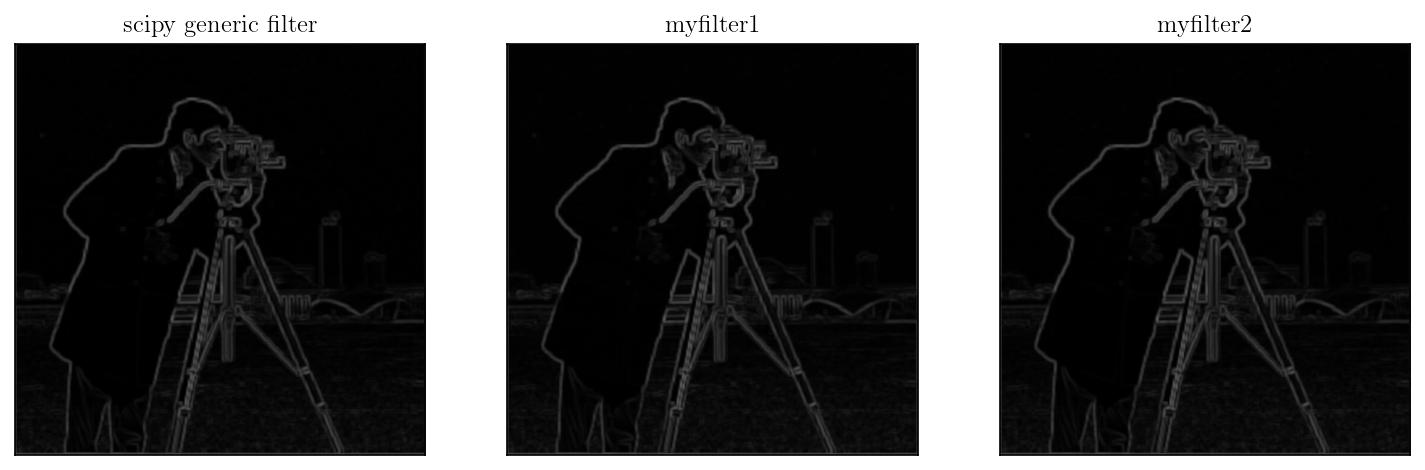

In [37]:
ksize=9
img1=generic_filter(img0, np.std, footprint=np.ones((ksize, ksize)), mode="constant")
img2=myfilter_gray_256(img0, "std", ksize)
img3=myfilter_gray_256_2(img0, "std", np.ones((ksize, ksize), np.int32))

fig1 = plt.figure(figsize=(12,8), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3 = fig1.add_subplot(131), fig1.add_subplot(132), fig1.add_subplot(133)
ax1.imshow(img1, cmap="gray", vmin=0, vmax=255)
ax2.imshow(img2, cmap="gray", vmin=0, vmax=255)
ax3.imshow(img3, cmap="gray", vmin=0, vmax=255)
ax1.set_title("scipy generic filter")
ax2.set_title("myfilter1")
ax3.set_title("myfilter2")

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [38]:
img2.min(), img2.max(), img3.min(), img3.max()

(0, 122, 0.0, 122.2066432270931)

In [40]:
ksize = 9
%timeit generic_filter(img0, np.median, footprint=np.ones((ksize, ksize)), mode="constant")
%timeit myfilter_gray_256(img0, "median", ksize)
%timeit myfilter_gray_256_2(img0, "median", np.ones((ksize, ksize), np.int32))
%timeit cv2.medianBlur(img0, ksize)

15.4 s ± 104 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.22 s ± 5.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.06 s ± 46.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
17.7 ms ± 12.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


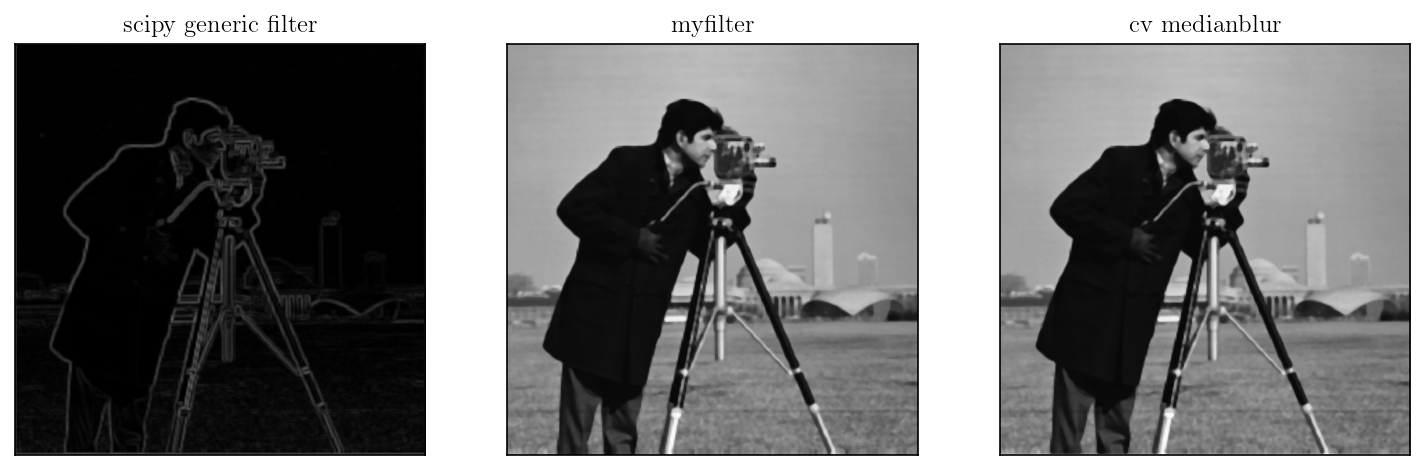

In [45]:
ksize=9
img5=generic_filter(img0, np.median, footprint=np.ones((ksize, ksize)), mode="constant")
img6=myfilter_gray_256_2(img0, "median", np.ones((ksize, ksize), np.int32))
img7=cv2.medianBlur(img0, ksize)
fig1 = plt.figure(figsize=(12,8), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3 = fig1.add_subplot(131), fig1.add_subplot(132), fig1.add_subplot(133)
ax1.imshow(img5, cmap="gray", vmin=0, vmax=255)
ax2.imshow(img6, cmap="gray", vmin=0, vmax=255)
ax3.imshow(img7, cmap="gray", vmin=0, vmax=255)
ax1.set_title("scipy generic filter")
ax2.set_title("myfilter")
ax3.set_title("cv medianblur")

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [47]:
img6

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0., 155., ..., 152.,   0.,   0.],
       [  0., 156., 156., ..., 152., 152.,   0.],
       ...,
       [  0., 128., 131., ..., 117., 112.,   0.],
       [  0.,   0., 129., ..., 113.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [46]:
img7

array([[159, 159, 157, ..., 156, 164, 179],
       [159, 158, 158, ..., 157, 164, 179],
       [158, 158, 157, ..., 157, 164, 179],
       ...,
       [159, 161, 167, ..., 153, 153, 170],
       [214, 214, 214, ..., 209, 209, 221],
       [237, 237, 237, ..., 236, 236, 236]], dtype=uint8)

In [52]:
cv2.medianBlur?

Docstring:
medianBlur(src, ksize[, dst]) -> dst
.   @brief Blurs an image using the median filter.
.   
.   The function smoothes an image using the median filter with the \f$\texttt{ksize} \times
.   \texttt{ksize}\f$ aperture. Each channel of a multi-channel image is processed independently.
.   In-place operation is supported.
.   
.   @note The median filter uses #BORDER_REPLICATE internally to cope with border pixels, see #BorderTypes
.   
.   @param src input 1-, 3-, or 4-channel image; when ksize is 3 or 5, the image depth should be
.   CV_8U, CV_16U, or CV_32F, for larger aperture sizes, it can only be CV_8U.
.   @param dst destination array of the same size and type as src.
.   @param ksize aperture linear size; it must be odd and greater than 1, for example: 3, 5, 7 ...
.   @sa  bilateralFilter, blur, boxFilter, GaussianBlur
Type:      builtin_function_or_method


In [50]:
img6.min(), img6.max()

(0.0, 250.0)

In [51]:
img7.min(), img7.max()

(7, 251)